# <center>ASTR4004/8004 - Simulations - Part 2</center>

This notebook builds a 1D hydrodynamic simulation, based on the following pseudocode (without adaptively refining grids):

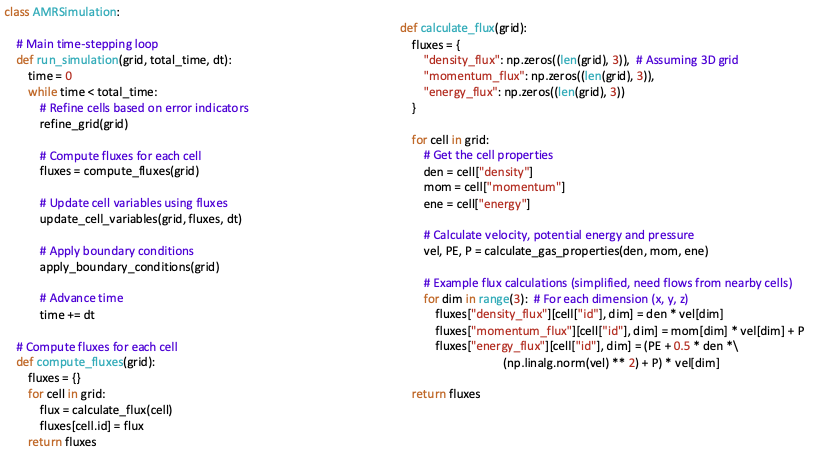

## Useful packages

In [1]:
import matplotlib
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## 1D simulation

In this tutorial, we focus on modeling the hydrodynamics of a fluid in one dimension (1D) by evaluating its esstetial properties, including density (`rho`), momentum, and total energy (`tte`) as functions of position `x`. We use a 2D grid (`grid`) to store these properties. Note that the total energy of the fluid system is composed of two primary components: static/internal energy (`ste`), which is related to the microscopic motions and interactions of the particles in the fluid; and kinetic/dynamic energy (`kte`), which is associated with the motion of the fluid. We derieve `ste` from the hydrostatic pressure (`p`) and `kte` from the fluid's velocity (`vel`).

We also assume uniform volume, hence `rho` = mass / volume = mass

In [2]:
# again grid is 2D, with the 1st, 2nd and 3rd column being density, momentum and total energy
def calculate_fluid_properties(grid):
    rho = grid[:,0]               # density
    vel = grid[:,1] / rho               # velocity
    kte = 0.5 * vel ** 2               # specific kinetic energy 
    ste = grid[:,2] / rho - kte               # specific static energy
    p   = (gamma-1)   * rho *ste             # hydrosatic pressure (gamma describes eos of ideal gas)
    
    return rho, vel, ste, kte, p

## Calculate fluxes

Let's now evaluate fluxes of density, momentum and energy in the 1D simulation. You can review the pseudocode above, but essentially:
* the density ($\rho$) flux ($F_{\rho}$) represents the transport of mass through a surface per unit area per unit time and is given by: $${F}_{\rho}=\rho v,$$(ignoring direction in 1D as negative and positive velocity $v$ represents its direction);
* the momentum ($P$) flux (${F}_{P}$) reflects the transport of momentum per unit area per unit time and can be expressed as: $$F_{P}=\rho v^2+p;$$
* the energy flux ($F_{E}$) accounts for the transport of energy and is evaluated as $$F_{E}=(\rho(kte+ste)+p)v,$$where `kte` and `ste` are the specific energies while $p$ is the hydrostatic pressure

In [3]:
def calculate_flux(grid):
    rho, vel, ste, kte, p = calculate_fluid_properties(grid)

    flux = np.zeros_like(grid)
    flux[:,0] = rho * vel
    flux[:,1] = rho * vel * vel + p
    flux[:,2] = (rho * (ste+kte) + p) * vel
    
    return flux

## Initilize the grid
We take `xlen` as input and initilize `grid` and `x`

### Sod's Shock Tube
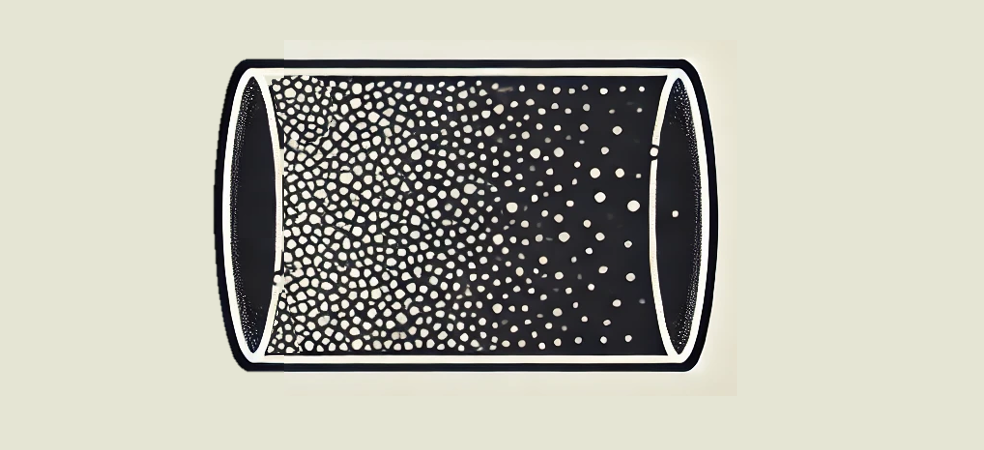

Here, we model the evolution of a high-pressure gas confined on one side of a diaphragm separated from a low-pressure gas on the other side. Upon removal of the diaphragm, the system evolves dynamically, giving rise to distinct wave structures that propagate through the medium. The problem is idealized to focus on fundamental hydrodynamic processes without the complexities introduced by multi-dimensional effects.

In [4]:
def sod_shock_tube(xlen):
    x    = np.linspace(xmin, xmax, xlen)
    grid = np.zeros((xlen, 3))

    # Sod's Shock Tube

    mid = xlen // 2
    grid[:mid, 0] = 1
    grid[mid:, 0] = 0.125
    
    pressure = np.where(x < 0.5, 1.0, 0.1)
    grid[:, 1] = 0
    grid[:, 2] = pressure / (gamma-1)

    # deal with boundary condition
    fill_BCs(grid)
    
    return grid, x

### Sedov-Taylor Blast Wave

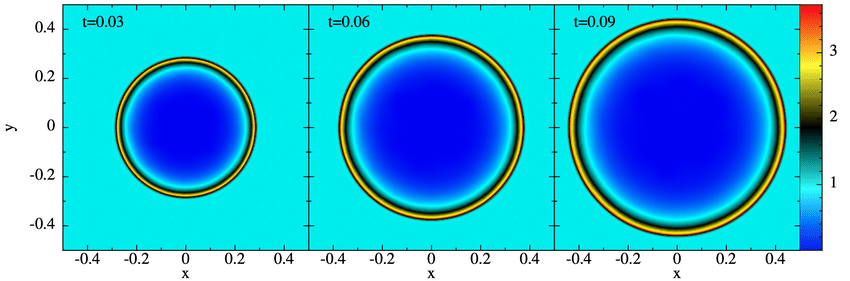

We will also model the propagation of a strong shock wave emanating from a point-like explosion in a homogeneous medium. This scenario involves an instantaneous injection of a substantial amount of energy, resulting in a highly nonlinear and dynamic evolution of the shock front. The solution is particularly relevant in astrophysical contexts, such as supernova explosions, where vast amounts of energy are released into the interstellar medium.

In [5]:
def sedov_taylor_blast_wave(xlen):
    x = np.linspace(xmin, xmax, xlen)
    grid = np.zeros((xlen, 3))

    # Sedov-Taylor Blast Wave
    radius = xlen // 10
    grid[:, 0] = 0.125
    grid[:, 1] = 0
    grid[:, 2] = 0
    grid[:radius,2] = 1

    # deal with boundary condition
    fill_BCs(grid)
    
    return grid, x

In [6]:
# let's pick an initial condition
def initialize_grid(xlen):
    return sod_shock_tube(xlen)

## Fill the boundary condition

We use the first and last component of `grid` to store two ghost cell. Ghost cells are additional cells added beyond the physical boundaries of the computational domain. They do not represent actual physical regions but are instead used to impose boundary conditions in a manner consistent with the numerical scheme employed such as updating properties based on flux. By extending the grid with ghost cells, one can apply various types of boundary conditions (e.g., reflective, outflow, inflow) without disrupting the internal computation logic.

In [18]:
def fill_BCs(grid):
    #Sod's Shock Tube (with zero-gradient "outflow")
    #grid[0]  = grid[1]
    #grid[-1] = grid[-2]
    
    #Sod's Shock Tube (with open end and real "outflow")
    #grid[0]    = grid[1]
    #grid[-1]   = grid[-2]
    #grid[0,2]  = 0.5 * (grid[0,1]/grid[0,0])**2
    #grid[-1,2] = 0.5 * (grid[-1,1]/grid[-1,0])**2

    #Sod's Shock Tube (with closed hard lid that fully bounces)   
    #grid[0]     = grid[1]
    #grid[-1]    = grid[-2]
    #grid[0,1]  *= -1
    #grid[-1,1] *= -1

    # periodical boundary / infinitely repeati1 Sod's Shock Tube
    grid[0]  =  grid[-2]
    grid[-1] = grid[1]

    # inflow boundary
    #grid[0,0]  = 1.0
    #grid[-1,0] = 0.125
    #grid[0,1]  = 0
    #grid[-1,1] = 0
    #grid[0,2]  = grid[0,0]/(gamma-1)
    #grid[-1,2] = grid[-1,0] / (gamma-1)

## Lax-Friedrichs Scheme

The Lax-Friedrichs scheme is a finite difference method designed to solve hyperbolic partial differential equations by approximating the solution at discrete grid points over time. It is particularly favored for its simplicity and robustness, especially in handling shock waves and discontinuities, albeit at the cost of introducing numerical diffusion which can smear sharp features.

For a generic 1D conservation equation:
$$ 
\frac{\partial{g}}{\partial{t}}+\frac{\partial{f(g)}}{\partial{x}}=0,
$$
where $g$ is the conserved quantity such as density, momentum and energy while $f(g)$ is its flux, the Lax-Friedrichs scheme updates $g$ based on:
$$
g_{x}^{t+1} = 0.5 (g_{x+1}^{t} + g_{x-1}^{t}) - 0.5 \Delta t / \Delta x (f_{x+1}^{t} + f_{x-1}^{t}).
$$
Here, $g_{x}^{t}$ and $f_{x}^{t}$ are $g$ and $f$ at grid point $x$ and time step $t$ while $\Delta t$ and $\Delta x$ are the time step and cell size.

In [16]:
dt         = 0.001    # timestep
Nframe     = 10000    # number of simulation steps
interval   = 1        # delay between movie frames in milliseconds 


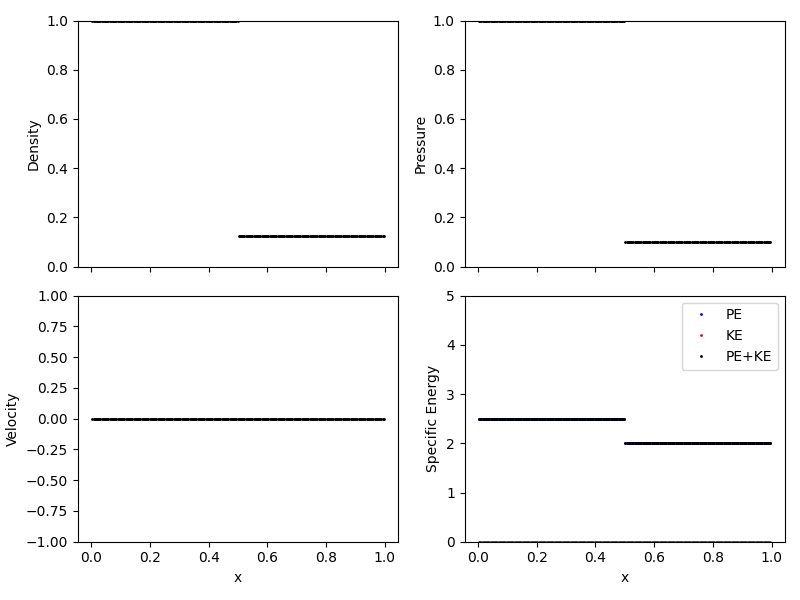

In [20]:
# Simulation parameters

nx    = 256       # number of cells
xlen  = nx + 2    # add two for ghost cells
xmin  = 0.0       # defining the domain range
xmax  = 1.0
dx    = (xmax - xmin) / (nx - 1)  # cell size
gamma = 1.4   # equation of state

# hydro run
def hydro():
    
    global grid

    grid, x = initialize_grid(xlen)

    rho, vel, ste, kte, p = calculate_fluid_properties(grid[1:nx + 1])

    fig, axs = plt.subplots(2,2, figsize=(8, 6), sharex=True)
    den_plot, = axs[0,0].plot(x[1:nx + 1], rho, color='k', markersize=1, ls='', marker='o')
    axs[0,0].set_ylabel("Density")
    axs[0,0].set_ylim(0,1)

    pre_plot, = axs[0,1].plot(x[1:nx + 1], p, color='k', markersize=1, ls='', marker='o')
    axs[0,1].set_ylabel("Pressure")
    axs[0,1].set_ylim(0,1)

    vel_plot, = axs[1,0].plot(x[1:nx + 1], vel, color='k', markersize=1, ls='', marker='o')
    axs[1,0].set_ylabel("Velocity")
    axs[1,0].set_xlabel("x")
    axs[1,0].set_ylim(-1,1)

    ste_plot, = axs[1,1].plot(x[1:nx + 1], ste, color='b', markersize=1, ls='', marker='o', label='PE')
    kte_plot, = axs[1,1].plot(x[1:nx + 1], kte, color='r', markersize=1, ls='', marker='o', label='KE')
    tte_plot, = axs[1,1].plot(x[1:nx + 1], ste+kte, color='k', markersize=1, ls='', marker='o', label='PE+KE')
    axs[1,1].set_ylabel("Specific Energy")
    axs[1,1].set_xlabel("x")
    axs[1,1].set_ylim(0,5)
    axs[1,1].legend(loc='upper right')

    plt.tight_layout()

    def evolve(it):
        
        global grid
        fill_BCs(grid)

        grid_new = np.zeros_like(grid)
        flux = calculate_flux(grid)
        for j in range(1, nx+1):
            grid_new[j] = 0.5 * (grid[j - 1] + grid[j + 1]) - 0.5 * dt / dx * (flux[j + 1] - flux[j - 1])
        
        grid = grid_new    
        rho, vel, ste, kte, p = calculate_fluid_properties(grid[1:nx + 1])

        den_plot.set_ydata(rho)
        pre_plot.set_ydata(p)
        vel_plot.set_ydata(vel)
        ste_plot.set_ydata(ste)
        kte_plot.set_ydata(kte)
        tte_plot.set_ydata(ste+kte)
        
    anim = FuncAnimation(
        fig,
        evolve,
        frames = Nframe,
        interval = interval,
        blit = True,
        repeat = False,
    )
   
    return anim


plt.close()
anim = hydro()